In [80]:
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [81]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [82]:
#what is the current working directory?
import os
os.getcwd()

'C:\\Users\\maden\\Documents\\DataProjects\\WiDS2020\\HiddenFigures\\02_code'

In [83]:
#Dependencies
import numpy as np
import pandas as pd
import re

from datetime import date, datetime

#set df scrolling
pd.set_option("display.max.columns",None)
#set df precision to 2 decimals for now...
pd.set_option("display.precision",2)
pd.set_option('display.max_rows',500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
enc = OneHotEncoder(handle_unknown = 'ignore')
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from string import ascii_letters
from pprint import pprint



# Load Test / Train Data

In [84]:
#Import Train Data
dfpath_train = "../01_data/training_NumericOnly.csv"
dfpath_test = "../01_data/testing_NumericOnly.csv"

df_train = pd.read_csv(dfpath_train)
print(df_train.shape)

df_test = pd.read_csv(dfpath_test)
print(df_test.shape)

target_col = 'hospital_death'

(91713, 178)
(39308, 178)


In [85]:
#We know the data is imbalanced.  There are way more survivals than there are deaths, as we would want in reality... 
print('Proportion of the classes in the data:')
print(df_train['hospital_death'].value_counts())
print(len(df_train))


Proportion of the classes in the data:
0    83798
1     7915
Name: hospital_death, dtype: int64
91713


# Preprocessing

In [86]:
#Later, do binary encoding and get dummies for categorical columns here

In [87]:
#How many NA records are in each column?
df_train.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                       0
age                               4228
bmi                               3429
elective_surgery                     0
height                            1334
icu_id                               0
pre_icu_los_days                     0
readmission_status                   0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache                18853
fio2_apache                      70868
gcs_eyes_apache                   1901
gcs_motor_apache                  1901
gcs_unable_apache                 1037
gcs_verbal_apache                 1901
glucose_apache           

In [88]:
df_test.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                   39308
age                               1654
bmi                               1086
elective_surgery                     0
height                             750
icu_id                               0
pre_icu_los_days                     0
readmission_status                   0
weight                             764
albumin_apache                   24650
apache_2_diagnosis                 896
apache_3j_diagnosis                637
apache_post_operative                0
arf_apache                         179
bilirubin_apache                 25292
bun_apache                        7016
creatinine_apache                 6896
fio2_apache                      29718
gcs_eyes_apache                   1163
gcs_motor_apache                  1163
gcs_unable_apache                  546
gcs_verbal_apache                 1163
glucose_apache           

In [89]:
#process categorical columns  (can use nunique to find these)
#must identify columns that might have medical codes in them
#in the example, they defined these as columns of more than 7 and less than 800 unique values

# print([c for c in df.columns if 7 <df[c].nunique()<800])

#identify columns that need encoded as numeric with label encoder  (so they are not currently a numeric)
# categorical_Cols = [c for c in df.columns if (1<df[c].nunique()) \
#                     & (df[c].dtype != np.number) & (df[c].dtype != int)]
# print(categorical_Cols)

#First fill in missing values in both datasets in these columns with ''
# df[categorical_Cols] = df[categorical_Cols].fillna("")

#Check to make sure it worked
# df[categorical_Cols].isna().sum()

ImportError: Can't determine version for numexpr

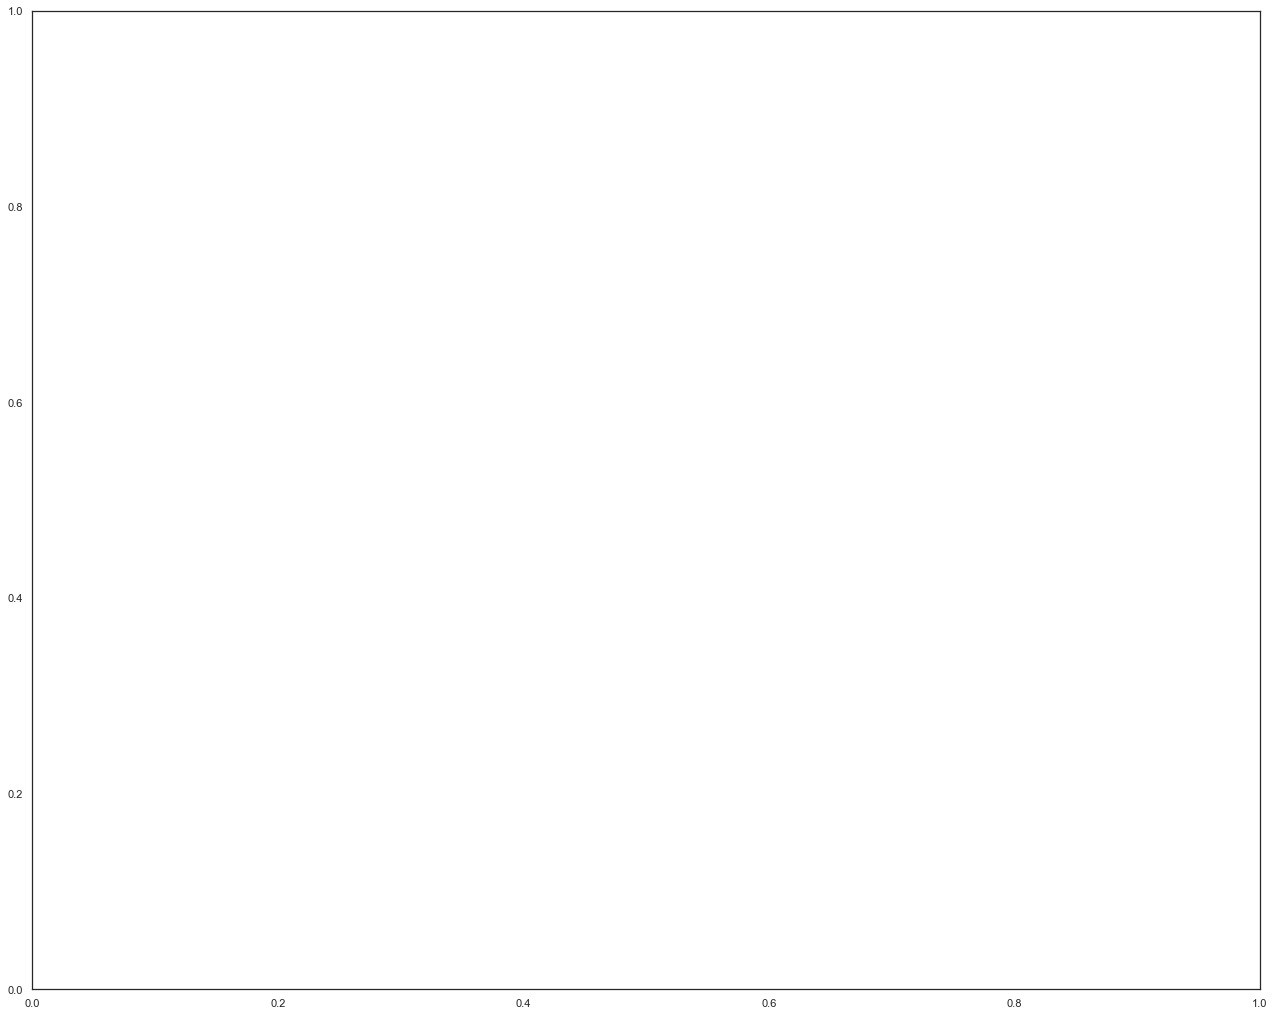

In [ ]:
sns.set(style="white")
#compute the correlation matrix
corr = df_train.corr()

#generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
###
### Compare the correlation between features and remove one of two features that have a correlation higher than 0.9

#There are some areas with heavy correlation
#Another way to reduce features is to remove some of the features with correlation higher than a set value.  
#Here, I will select 0.9

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_train.columns[columns]
df_train = df_train[selected_columns]
df_test = df_test[selected_columns.drop(['hospital_death'])]

df_train.head()

In [ ]:
df_test.head()

# Handle NaN Values

In [ ]:
#Handle the NaN values in the rows  (remove, impute, or find algorithm that allows them)

# #Example 1: Remove Missing Values  (Will significantly reduce our dataset)
# #drop columns with > 25% of rows with missing values  - How does this impact our dataset?
# threshold = int(len(df) * .5)
# print(threshold)
# df = df.dropna(thresh = threshold, axis = 1)
# df.head()

# Example 2:  Imputing  (mean,median,mode, randomly selected, value estimated from another model (liek nearest neighbors))
#Use the imputer function to replace the NaN values
#I liked this for help... https://www.kaggle.com/learn-forum/62035
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
#Fit the data, function learns the stats
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train))
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test))
#add titles back
df_train_imputed.columns = df_train.columns
df_test_imputed.columns = df_test.columns

df_train = df_train_imputed
df_train.head()

#Example 3: Select ML algorithm that allows NaN values



In [ ]:

df_test = df_test_imputed
df_test.head()


In [ ]:
#CHECK TO MAKE SURE MISSING VALUES HAVE BEEN IMPUTED
print(df_train.shape)
#How many NA records are in each column?
df_train.isna().sum()

In [ ]:
# ###
# ### Select columns base on how they affect the p-value.
# #Remove prediction colun ('hostpital_death')

# selected_columns = selected_columns.drop(['hospital_death']).values
# print(selected_columns)

# ### I DO NOT UNDERSTAND HOW THIS WORKS YET
# '''This is what we are doing in the above code block:
# We assume to null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”.
# Then we build a small regression model and calculate the p values.
# If the p values is higher than the threshold, we discard that combination of features.'''

# import statsmodels.formula.api as sm

# def backwardElimination(x, Y, sl, columns):
#     numVars = len(x[0])
#     for i in range(0, numVars):
#         regressor_OLS = sm.OLS(Y, x).fit()
#         maxVar = max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#                     columns = np.delete(columns, j)
                    
#     regressor_OLS.summary()
#     return x, columns
# SL = 0.05

# data_modeled, selected_columns = backwardElimination(df_train.iloc[:,1:].values, df_train.iloc[:,0].values, SL, selected_columns)



# # #Recreate the df with the selected columns using p-value and correlation

# #move predctor column to new dataframe
# result = pd.DataFrame()
# result['hospital_death'] = df_train['hospital_death']
# result.head()

# data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# data.head()

# data.describe()

# #Visualize the Features
# fig = plt.figure(figsize = (20, 25))
# j = 0
# for i in data.columns:
#     plt.subplot(6, 4, j+1)
#     j += 1
#     sns.distplot(data[i][result['hospital_death']==0], color='g', label = 'survival')
#     sns.distplot(data[i][result['hospital_death']==1], color='r', label = 'death')
#     plt.legend(loc='best')
# fig.suptitle('TITLE HERE')
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.show()

# Normalize the Data to Handle Data Skew

In [ ]:
df_train.head()

In [ ]:
df_test.head()

# Prepare for Machine Learning

In [ ]:
#Column names being fed to model minus the prediction column
features = df_train.drop(['hospital_death', 'encounter_id','patient_id'], axis = 1).columns.values
print(type(features))

In [12]:
#Pop out the columns that are only identifiers  ie. encounter and patient id 
# These can be merged back into the result later
identifiers_train = df_test[['encounter_id','patient_id']]
identifiers_train.head()


,encounter_id,patient_id
0,2,127112
1,5,130737
2,7,101458
3,8,48067
4,10,25865


In [13]:
identifiers_test = df_test[['encounter_id','patient_id']]
identifiers_test.head()

,encounter_id,patient_id
0,2,127112
1,5,130737
2,7,101458
3,8,48067
4,10,25865


In [14]:
#Select Specific Features
df_train = df_train.drop(['encounter_id','patient_id'], axis = 1)
df_train.head()

,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,118,0,68.0,22.73,0,180.3,92,5.42e-01,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,81,0,77.0,27.42,0,160.0,90,9.28e-01,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1.0,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0,67.0,159.0,67.0,36.3,35.1,NaN,NaN,61.0,4

In [15]:
df_test = df_test.drop(['encounter_id','patient_id'], axis = 1)
df_test.head()

,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,7,NaN,56.0,21.10,0,180.3,1105,1.04e-01,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,NaN,NaN,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,NaN,NaN,19.50,1,145.0,1043,2.31e-01,0,41.0,NaN,217.0,1502.02,1,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,60.0,NaN,0.0,53.0,NaN,NaN,NaN,NaN,37.0,NaN,37.0,843.44,0.0,NaN,NaN,NaN,65.0,31.0,65.0,31.0,73.0,60.0,NaN,NaN,108.0,53.0,108.0,53.0,33.0,16.0,99.0,90.0,NaN,NaN,148.0,83.0,148.0,83.0,37.7,36.6,NaN,NaN,50.0,44.0,50.0,44.0,60.

# Test / Train Split

In [16]:
#useful function:  df._get_numeric_data() will return only numeric columns from a pd dataframe - good for ML models

In [17]:
X = df_train.drop([target_col], axis = 1)  #drop off the column to predict
y = df_train[target_col].values.reshape(-1,1)

In [18]:
X.head(2)

,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,118,68.0,22.73,0,180.3,92,0.54,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,81,77.0,27.42,0,160.0,90,0.93,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1.0,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0,67.0,159.0,67.0,36.3,35.1,NaN,NaN,61.0,48.0,61.0,48.0,114.0,100.0,N

In [19]:

print(X.shape, y.shape)

(91713, 175) (91713, 1)


In [20]:
print(df_test.shape)

(39308, 176)


In [21]:
#Normalize the data  / This needs to be moved up?
### #StandardScaler applies a Guassian distribution to our data where the mean is 0 and the standard deviation is 1. 
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
df_test_scaler = StandardScaler().fit(df_test)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
df_test_scaled = df_test_scaler.transform(df_test)


X = X_scaled
y = y_scaled


C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-pa

In [22]:
#### TEST TRAIN SPLIT #####
# Use train_test_split to create training and testing data from our "train" dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)

In [23]:
# #### K-Folds ####
# # Use K-Folds to create training and testing data from our "train" dataset
# from sklearn.model_selection import KFold

# kf = KFold(n_splits = 5) # Define the split into "n" folds
# kf.get_n_splits(X_scaled)  # returns the number of splitting iterations in the cross-validator

# print(kf)


# for train_index, test_index, in kf.split(X_scaled):
#     print("TRAIN:", train_index, "Test:", test_index)
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y_scaled[train_index], y_scaled[test_index]



# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

In [25]:
#Fix Data Type
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

# Fit regression model
model = LogisticRegression()
model.fit(X_train, y_train_encoded)
predictions = model.predict(X_test)

training_score = model.score(X_train, y_train_encoded)
testing_score = model.score(X_test, y_test_encoded)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

[0 0 0 ... 0 0 0]
continuous
binary
binary


C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
coef = []
for c in np.nditer(model.coef_, order = 'K'):
    coef.append(float(c))
print(coef)

In [ ]:
coef_dict = {}
for coef, feat in zip(coef, features):
    coef_dict[feat] = coef

In [ ]:
sorted_coef = sorted(((v, k) for (k, v) in coef_dict.items()), reverse = True)
pprint(sorted_coef)

# Random Forest Classifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

In [ ]:
# #Fix Data Type
# lab_enc = preprocessing.LabelEncoder()
# y_train_encoded = lab_enc.fit_transform(y_train)
# y_test_encoded = lab_enc.fit_transform(y_test)
# print(y_train_encoded)
# print(utils.multiclass.type_of_target(y_train))
# print(utils.multiclass.type_of_target(y_train.astype('int')))
# print(utils.multiclass.type_of_target(y_train_encoded))

# X_train, y_train_encoded = make_classification(n_features=116,n_informative=2, n_redundant=0,random_state=0, shuffle=False)

# model = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
# model.fit(X_train, y_train_encoded)
# predictions = model.predict(X_test)

# training_score = model.score(X_train, y_train_encoded)
# testing_score = model.score(X_test, y_test_encoded)

# print(f"Training Score: {training_score}")
# print(f"Testing Score: {testing_score}")


In [ ]:
# print(model.feature_importances_)

In [ ]:
#Confusion Matrix (Seaborn)
#This is where we look at False positive, False negative etc. 

conf_matrix = metrics.confusion_matrix(y_test_encoded, predictions )


#this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
plt.title(all_sample_title, size = 15);

In [ ]:
#Now we need to be able to get the prediction into the format needed for submittal
#add feature importances in here too, so that we can improve! 

In [ ]:
print(target_col)

In [ ]:
#Make new prediction on the df_test data
df_test[target_col] = model.predict(df_test_scaled)
#df_test[target_col] = model.predict_proba(df_test_scaled)[:,1]
#df_test[target_col] = model.predict_proba(df_test_scaled)


In [ ]:
#add the identifier "encounter_id" back in


In [ ]:
df_test['encounter_id'] = identifiers_test['encounter_id']

In [ ]:
#Convert encounter_id to int32
df_test['encounter_id'] = pd.to_numeric(df_test['encounter_id'],downcast = 'integer')

In [ ]:
output = df_test[['encounter_id','hospital_death']]
output.head()

In [ ]:
df_test['encounter_id'].dtype

In [ ]:
output.to_csv("../06_submissions/" + str(date.today()) + "_" + ".csv", index=False)